- Benjamin Makowsky
- A14726324

# Human ECoG Task Data
**Introduction**
>I was curious about the stregth of the signal in the brain corresponding to the fingers on the hand. The homonculus depictions are always shown with the thumb being represented in the brain larger than the other fingers. This observation lead me to hypothesize that because the thumb is so important to our dexterity and is represented within a larger portion of the brain, it's signal would likewise be stronger than the other fingers. I intend on answering this question by analyzing a study where participants were asked to move a finger according to a cue displayed on screen. The signals corresponding to the fingers were recorded from the dorsal primary motor cortex. In order to process the signal, several techniques were used including; fourier analysis, filtering, and ERP (averaging). 

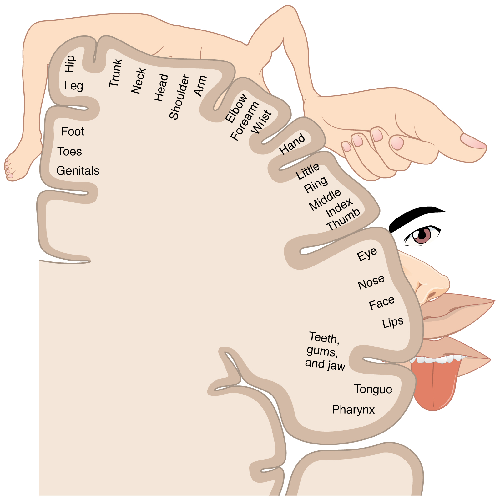

In [7]:
from PIL import Image
img = Image.open('img/sh.jpg').resize((500,500))
img

#### Dataset
> The dataset is comprised of rocordings from the human sensorimotor region. Data was collected using ECoG and was sampled at 1000Hz from **Miller et al., JNeuro, 2007**.

> For the study, patients were told to sit in a chair and observe a monitor. The monitor would present a cue for 2 seconds which would indicate to them which finger to move.

**Research Question:**
>Does signal strength increase with finger dominance?

**Hypothesis:**
>The thumb and index finger will create the largest spike when being moved

In [8]:
%matplotlib inline
import numpy as np
from scipy import io, signal # we will also import the signal module, from scipy
import matplotlib.pyplot as plt

In [9]:
human_ecog_data = io.loadmat('ECoG_human/ECoG_human.mat', squeeze_me = True)
fs = human_ecog_data['fs'] #1000hz
data_M1a = human_ecog_data['ecog_task'][:,0]  #First M1 Electrode
data_M1b = human_ecog_data['ecog_task'][:,1]  #Second M1 Electrode
avg_d = (data_M1a + data_M1b) / 2 * human_ecog_data['scale'] #Combine the 2 dorsal electrodes into 1
cue = human_ecog_data['cue']
t = np.arange(0,avg_d.shape[0]/fs,1/fs)

#### Plotting the signal and cue times together

Text(0.5,0,'Time (s)')

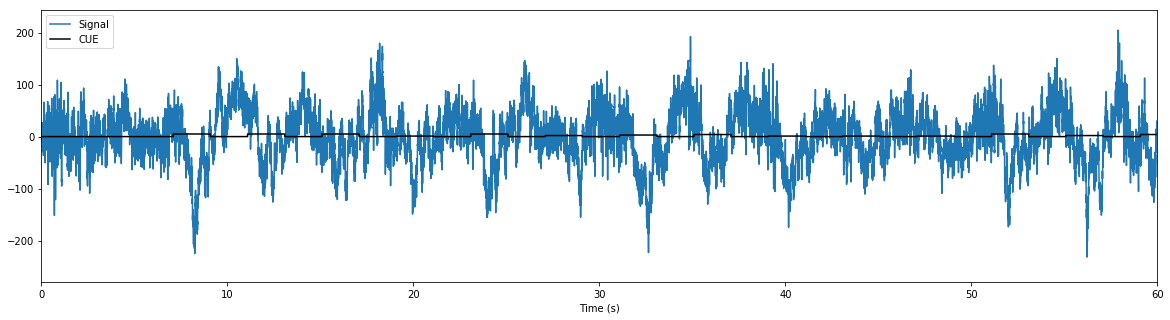

In [10]:
plt.figure(figsize=(20,5))
plt.plot(t,avg_d,label='Signal')  #Plot the combined signal
plt.plot(t, cue,color='black', label='CUE') #Plot the cue times on top
plt.xlim(0,60) #plot the first 30 seconds
plt.legend();plt.xlabel('Time (s)')

>The above graph illustrates the first 60 seconds of the study. As you can see, there is a lapse in time from the cue to twhen the signal changes. This is because it takes a person a short while for a person to begin movement after seeing the cue. However, because the study was performed in doors there is a high chance of electrical interference is the 60 hz range. As a result I decided to first perform a fourier analysis to determine if there were any frequencies contributing to the signal and distorting it.

### Fourier Analysis

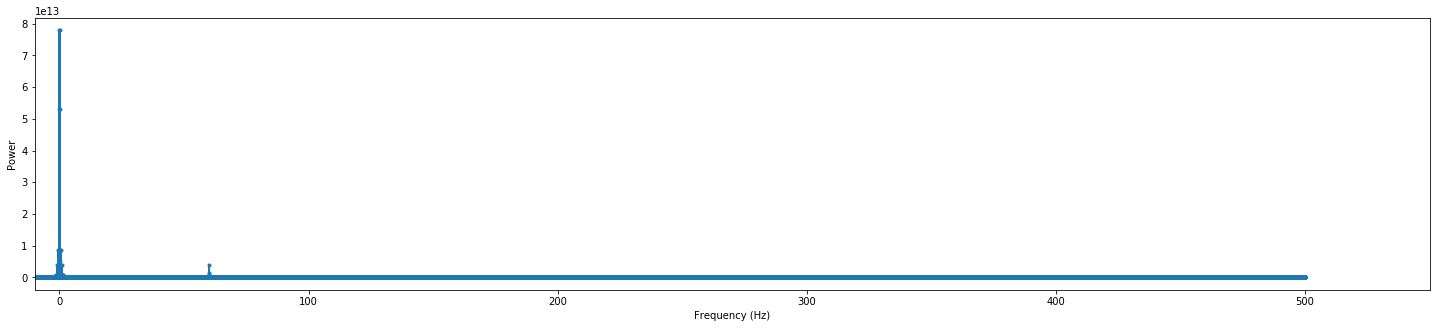

In [11]:
ft = np.fft.fft(avg_d) #Convert to frequency domain
ps = np.abs(ft)**2     #get power
freqs = np.fft.fftfreq(len(avg_d), 1/fs)  #Get all frequencies
plt.figure(figsize=(25,5))
plt.plot(freqs, ps,'.-')    #Plot power as a function of frequency
plt.xlim(-10,)
plt.xlabel('Frequency (Hz)'); plt.ylabel('Power');

> Just as predicted. there is some noise down at the 60hz region of the graph. This is very common in most indoor signal analysis inside of America because of the powerlines near by. American power runs at 60hz which will distort the signal we are studying. As a result we are going to run a lowpass filter and filter out the 60hz noise.

#### Filtering

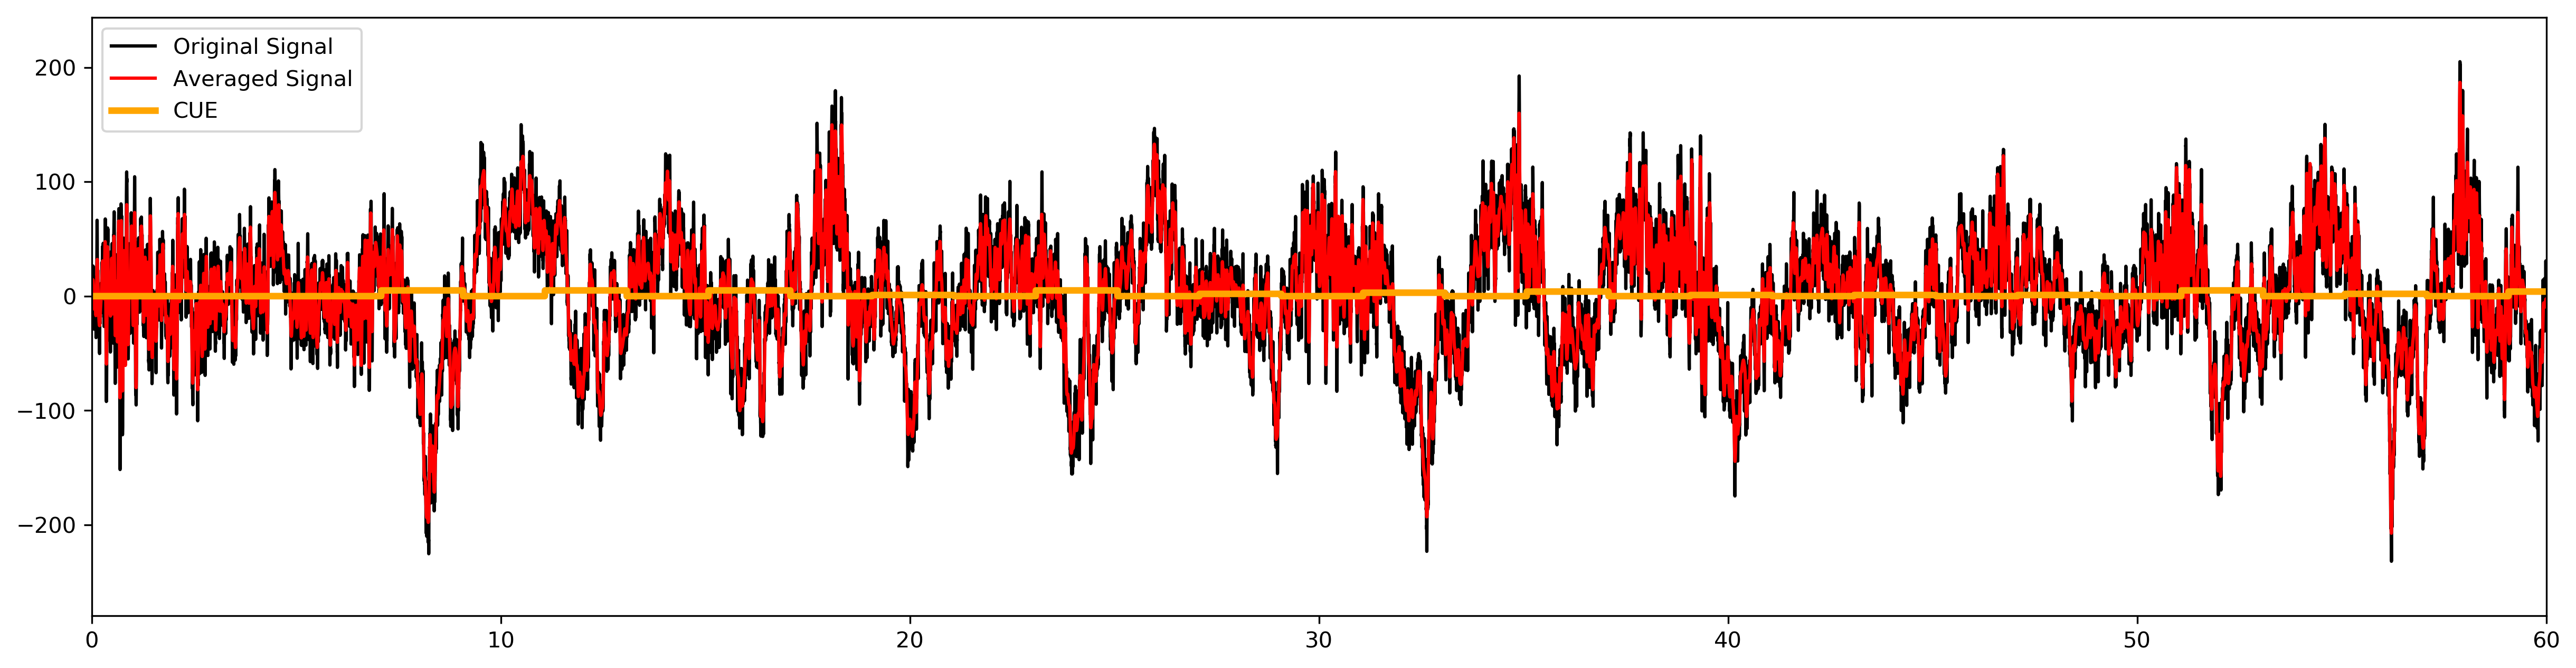

In [12]:
cutoff = 20#hz
filt_order = int(3*fs/cutoff)+1
filt_coefs = signal.firwin(filt_order, cutoff=cutoff, fs=fs, pass_zero=True)

# compute the magnitude and phase response of the filter
freq_resp = np.fft.fft(filt_coefs, n=int(fs))
mag_resp = abs(freq_resp)**2
ph_resp = np.angle(freq_resp)
freqs = np.fft.fftfreq(int(fs),1/fs)
filtered_avg = np.convolve(avg_d,filt_coefs,mode='same')

plt.figure(figsize=(20,5),dpi=300)
plt.subplot(111,facecolor='white')
plt.plot(t, avg_d, color = 'black',label='Original Signal')
plt.plot(t,filtered_avg,color='red', label='Averaged Signal')
plt.plot(t, cue,lw =3,color='orange', label='CUE')
plt.xlim(0,60);plt.legend()

#### Windowing and ERP (Averaging)

> The plot confirms that the signal was affected by the 60hz noiseand now that the signal has been filtered for noise we can analyze each finger's activation in the brain. In order to determine the stregnth of each finger's signal I took the average over each trial for that individual finger. This was done by matching the indices of the cue and it's corresponding number to the indices within the overall signal.

In [13]:
def getFingerWindows(signal, finger):
    windows = list()   #Create an empty list to hold all the indices
    i = 0              #Start at zero
    start = 0
    stop = 0
    while (i < len(signal)):     #iterate through every element in the array
        if(signal[i] == finger): #If the cue value equals the finger you are looking for begin indexing
            start = i            #Start is the first instance where i = finger
            while(signal[i] == finger): #while i is equaling the same finger skip foward
                i += 1
            stop = i - 1
            windows.append(np.arange(start,stop,1))  #append all the windows together
        i += 1
    return np.array(windows)

In [14]:
#Create an average of all the windows of the same number
def sig_avg(signal, indices):
    avg = signal[indices[0]]  #Get the first window
    counter = 1               #Count the first windows
    while counter < indices.shape[0]:  #While not at the end of the windows
        avg = avg + signal[indices[counter]] #Add the values in the windows together
        counter += 1
    avg = avg / counter
    return avg    

In [17]:
windows5 = getFingerWindows(human_ecog_data['cue'], 5) #Pinky
windows4 = getFingerWindows(human_ecog_data['cue'], 4) #Ring
windows3 = getFingerWindows(human_ecog_data['cue'], 3) #Middle
windows2 = getFingerWindows(human_ecog_data['cue'], 2) #Index
windows1 = getFingerWindows(human_ecog_data['cue'], 1) #Thumb
avg_signal5 = sig_avg(filtered_avg, windows5)
avg_signal4 = sig_avg(filtered_avg , windows4)
avg_signal3 = sig_avg(filtered_avg , windows3)
avg_signal2 = sig_avg(filtered_avg , windows2)
avg_signal1 = sig_avg(filtered_avg , windows1)
t_avg = np.arange(0,len(avg_signal1)/fs,1/fs)

(0, 2)

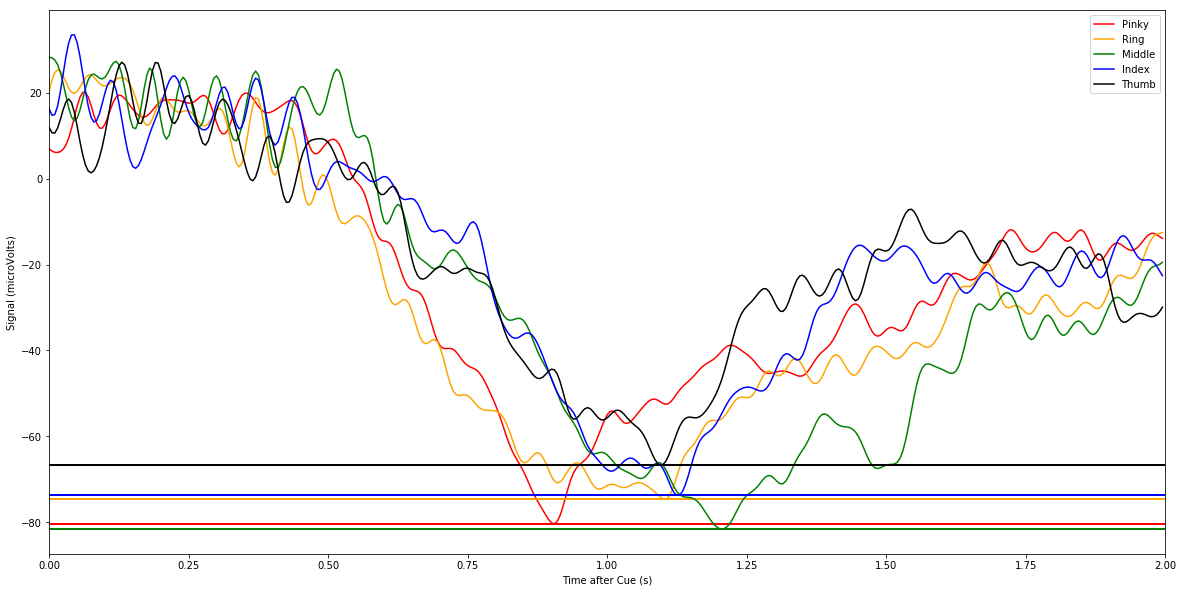

In [44]:
plt.figure(figsize=(20,10))
down_rate = 5

plt.plot(t_avg[::down_rate],avg_signal5[::down_rate],label ='Pinky',color ='red')
plt.axhline(y=np.min(avg_signal5[::down_rate]),ls='-',lw=2,color = 'red')

plt.plot(t_avg[::down_rate],avg_signal4[::down_rate],label ='Ring',color ='orange')
plt.axhline(y=np.min(avg_signal4[::down_rate]),ls='-',lw=2,color = 'orange')

plt.plot(t_avg[::down_rate],avg_signal3[::down_rate],label ='Middle',color ='green')
plt.axhline(y=np.min(avg_signal3[::down_rate]),ls='-',lw=2,color = 'green')

plt.plot(t_avg[::down_rate],avg_signal2[::down_rate],label ='Index',color ='blue')
plt.axhline(y=np.min(avg_signal2[::down_rate]),ls='-',lw=2,color = 'blue')

plt.plot(t_avg[::down_rate],avg_signal1[::down_rate],label ='Thumb',color ='black')
plt.axhline(y=np.min(avg_signal1[::down_rate]),ls='-',lw=2,color = 'black')

plt.legend();plt.xlabel('Time after Cue (s)');plt.ylabel('Signal (microVolts)');plt.xlim(0,2)

>The data was downsampled by a facor of 100 in order to clean up the lines and make it more easily distinguishable what was happening  for each finger. The downsampling had no effect on the ordering of the lines as for which finger had the largest response.

In [27]:
def compute_power(signal, fs):
    ft = np.fft.fft(signal) #Convert to frequency domain
    ps = np.abs(ft)**2     #get power
    freqs = np.fft.fftfreq(len(signal), 1/fs)  #Get all frequencies
    return ps
    

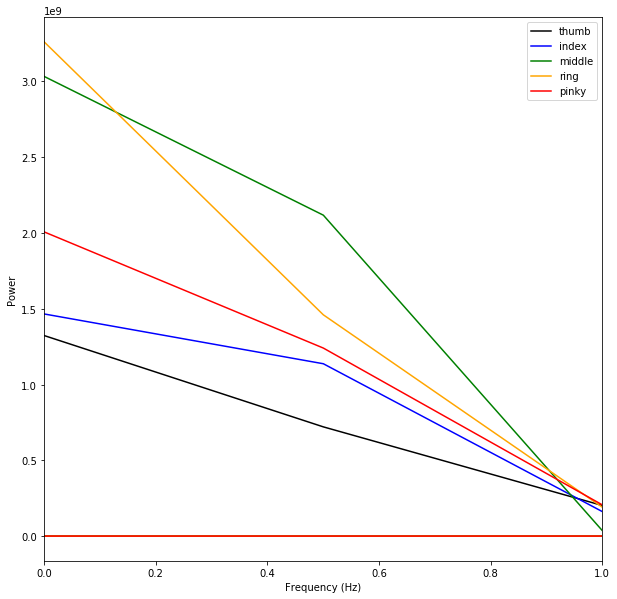

In [39]:
plt.figure(figsize=(10,10))
plt.plot(np.fft.fftfreq(len(avg_signal1), 1/fs), compute_power(avg_signal1,fs),label='thumb',color='black')    #Plot power as a function of frequency
plt.plot(np.fft.fftfreq(len(avg_signal2), 1/fs), compute_power(avg_signal2,fs),label='index',color='blue')    #Plot power as a function of frequency
plt.plot(np.fft.fftfreq(len(avg_signal3), 1/fs), compute_power(avg_signal3,fs),label='middle',color='green')    #Plot power as a function of frequency
plt.plot(np.fft.fftfreq(len(avg_signal4), 1/fs), compute_power(avg_signal4,fs),label='ring',color='orange')    #Plot power as a function of frequency
plt.plot(np.fft.fftfreq(len(avg_signal5), 1/fs), compute_power(avg_signal5,fs),label='pinky',color='red')    #Plot power as a function of frequency
plt.xlim(0,1);plt.xlabel('Frequency (Hz)'); plt.ylabel('Power');plt.legend()

**Results:**
>The results of my analysis contradict my hypothesis and therefore it can be concluded that the primary fingers do not create the largest response. Rather the data shows that the largest response comes from the other fingers with the pinky consistently being among the top.

**Discussion:**
> The reasoning behind whe results of my analysis cannot be easily determined. My new hypothesis is that the regions with a larger represent in the brain have a decreased signal strength. This could be because as the brain devotes more area to a region the signal does not need be as strong because of the summation of the regionis in the brain.